# Deep Learning for Natural Language Processing

----
## Table of Content
----

<a href='#section1'> 1. Introduction</a>

__PART 1: Sentiment Analysis__

<a href='#section2'>2. Text Representation in DL</a>
> <a href='#section2_load_data'>2.1 Load data</a>

> <a href='#section2_examin_data'>2.2 Examine the dataset</a>

> <a href='#section2_one_hot'>2.3 One-hot encoding of the data</a>

> <a href='#section2_word_index'>2.4 Inspect created word-index</a>

<a href='#section3'>3. What's going on inside a MLP</a>

<a href='#section4'>4. MLP in Keras</a>

> <a href='#section4_model_optimization'>4.1. Model Optimization</a>

<a href='#section5'>5. Other models for text</a>

> <a href='#section5_padding'>5.1 Padding sequences </a>

> <a href='#section5_lstm'>5.2 Build a LSTM model in few lines</a>

> <a href='#section5_cnn'>5.3 1D CNN for texts (optional)</a>


__PART 2: Word Embeddings__

<a href='#section6'>6. Set up</a>

<a href='#section7'>7. Task 1: Semantically similar/related words</a>

<a href='#section8'>8. Task 2: Semantic orientation</a>

<a href='#section9'>9. Task 3: Analogy</a>

<a href='#section10'>10. Visualization (optional)</a>

----

<a id='section1'></a>
## 1. Introduction

This lab session is organized in two main parts. The first part is devoted to build a classifier for textual input. In the second part we will work with word embeddings to understand their usefulness.  

### Part 1: Sentiment Analysis (1h approx)

In first part we will implement a series models for __sentence classification__ using Keras and TensorFlow. Given a sentence our model will predict if it is a positive or negative piece of texts. The dataset we are going to use ranges the polarity annotation from 0 to 5, where 0 denotes extremelt negative sentiment,  and 5  is the most  positive. 

Nevertheless, for this lab we will simplify the task, and we will translate the 5-way classification task (actually [0-5] regression task) into 2-way classification task (0 $\rightarrow$ _negative,_ ;1 $\rightarrow$ positive),

All in all, the main __objectives__ of this lab session for this part are the following: 
- How to represent text as input of neural network models (the _one-hot econding_).
- Understant the mechanics of a Multi-Layer Perceptron (a.k.a Feedforward layer) with TensorFlow.
- Learn how to build, train and evaluate suitable for text model in Keras.

-----

Optionally, once you finished the whole lab, you could explore following things:
- Explore hyperparameters like:
  - Optimizers: SGD, ADAGRAD, etc.
  - Learning Rates
  - Regularization (more on this next lab)
- Plot learning curves for model selection

----

### Part 2: Word Embeddings (1h approx)

In the second part of the session  we will learn how to work with word embeddings. We show that applying simple techniques we can implement very cool stuff. 

This part is divided in many parts that in most of the cases do not need code implementation. Hopefully, you would complete the assignment in a short time and have great fun too. 

The main __objective__ of this part is to learn about some interesting task that can be acomplish with word embeddings:

- __Task 1__: Word similarity and relatedness
- __Task 2__: Score semantically the words
- __Task 3__: Do analogies, like _Man is to King like Woman is to Queen_

------

## Exercise Index
__Part 1 exercises__:

<a href='#exercise1'>Exercise 1: Most vs leas frequent words</a>

<a href='#exercise2'>Exercise 2: Coding MLP</a>

<a href='#exercise3'>Exercise 3: Vocab size effect</a>

<a href='#exercise4'>Exercise 4: Model optimization</a>

<a href='#exercise5'>Exercise 5: One-hot encoding vs Embedding encoding</a>

<a href='#exercise6'>Exercise 6: Building a LSTM</a>

<a href='#exercise7'>Exercise 7 (optional): 1D CNN for text</a>

-----
__Part 2 exercises__:

<a href='#exercise8'>Exercise 8: Word similarity/relatedness</a>

<a href='#exercise9'>Exercise 9: Semantics orientation</a>

<a href='#exercise10'>Exercise 10: Analogy</a>

<a href='#exercise11'>Exercise 11: Visualization (optional)</a>

# PART 1: Sentiment Analysis

<a id='section2'></a>
## 2. Text Representation in DL

Once data is loaded the next step is to preprocess it to obtain the vectorized form (i.e. the process of transforming text into numeric tensors), which basically consist of:

- Tokenization, tipically segment the text into words. (Alternatively, we could segment text into characters, or extract n-grams of words or characters.)
- Definition of the dictionary index and vocabulary size (in this case we set to 1000 most frequent words)
- Transform each word into a vector. 


There are multiple ways to vectorize tokens. The main two are the following: ___One-hot encoding___ and ___word embedding___. In the first part of the lab, we'll make use of the basic tools provided by Keras to obtain __the one-hot encoding__. 


-----

<a id='section2_load_data'></a>
### Load data

We provide the __Movie Review from Rottern Tomatoes dataset (MRRT)__ dataset for sentiment analysis, which the original can be downloaded from [here](https://www.cs.cornell.edu/people/pabo/movie-review-data/). We are using version 1.0. Please, __download__ the dataset ready for the lab from here:

- Download data from [this link](https://www.dropbox.com/s/kej8qc13fhgdd8c/data.tar.bz2?dl=0)


Place the decompressed file in the same path of the notebook. You should have the dataset in the current folder: ```./data/rt-polaritydata/```


In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.utils import shuffle


def clean_str(string):
    """
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def load_data_and_labels(pos_file, neg_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    positive_examples = list(open(pos_file, "r").readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(open(neg_file, "r").readlines())
    negative_examples = [s.strip() for s in negative_examples]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text]
    # Generate labels
    positive_labels = [1 for _ in positive_examples]
    negative_labels = [0 for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    data = pd.DataFrame(data={'text': x_text, 'label': y})
    data = shuffle(data)
    return data

Load data and make train and development partitions:

In [2]:
# data home
sst_home = './data/rt-polaritydata/'
dataset = load_data_and_labels(sst_home+'/rt-polarity.pos', sst_home+'rt-polarity.neg')

print("dataset size:", dataset.shape)

training_set = dataset.head(9000)
dev_set = dataset.tail(1000)

# Obtain text and label vectors as lists 
train_texts = list(training_set.text)
train_labels = list(training_set.label)

dev_texts = list(dev_set.text)
dev_labels = list(dev_set.label)

print('')
print('Training set examples: {}'.format(len(training_set)))

print('Development set examples: {}'.format(len(dev_set)))

dataset size: (10662, 2)

Training set examples: 9000
Development set examples: 1000


<a id='section2_examin_data'></a>
### Examine the dataset
We print some example of negative and positive cases, just to make an idea of what type of text we have.  

In [3]:
# Print a sample of negative text chunks
training_set[training_set.label == 0].head(10)

,text,label
8337,suffocated at conception by its munchausen by ...,0
6578,this loud and thoroughly obnoxious comedy abou...,0
6452,"ze movie starts out so funny , then she is not...",0
7454,"most new movies have a bright sheen some , lik...",0
5857,standard guns versus martial arts cliche with ...,0
7668,every bit as bogus as most disney live action ...,0
8097,"preposterous and tedious , sonny is spiked wit...",0
8257,fairly successful at faking some pretty cool s...,0
10323,"has not so much been written as assembled , fr...",0
6083,it 's drab it 's uninteresting it squanders ch...,0


In [4]:
# Print a sample of positive text chunks
training_set[training_set.label == 1].head(10)

,text,label
948,an enjoyably half wit remake of the venerable ...,1
2178,it 's no lie big fat liar is a real charmer,1
1246,this riveting world war ii moral suspense stor...,1
4820,grown up quibbles are beside the point here th...,1
3234,despite its old hat set up and predictable plo...,1
2140,runs on the pure adrenalin of pacino 's perfor...,1
499,does what a fine documentary does best it exte...,1
5312,"arliss howard 's ambitious , moving , and adve...",1
1154,a warm but realistic meditation on friendship ...,1
624,do we really need a 77 minute film to tell us ...,1


<a id='section2_one_hot'></a>
### One-hot encoding of the data

One-hot encoding is the most basic way to convert a token into a vectort. Here, we'll turn the input vectors into (0,1)-vectors. The process consist of associating a unique integer-index with every word in the vocabulary.

>>>>![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/vectorize_small.png)


For example, if the tokenized vector contains a word that its dictionary index is 14, then in the processed vector, the 14th entry of the vector will be 1 and the rest will set to 0.

Note that when using keras built-in tools for indexing, ```0``` is a reserved index that won't be assigned to any word.

In [5]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

# Create a tokenize that takes the nb_words most common words
nb_words= 5000 # Changed from 1000
tokenizer = text.Tokenizer(num_words=nb_words)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part

# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts, mode='binary')
x_dev = tokenizer.texts_to_matrix(dev_texts, mode='binary')
          
# Change variable names (not needed, actually)
y_train = train_labels
y_dev = dev_labels

print('Text of the first examples: \n{}\n'.format(train_texts[0]))
print('Vector of the first example:\n{}\n'.format(x_train[0]))
print('Binary representation of the output:\n{}\n'.format(y_train[0]))

print('Shape of the training set (nb_examples, vector_size): {}\n'.format(x_train.shape))

/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/juletx/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Text of the first examples: 
suffocated at conception by its munchausen by proxy mum punish the vehicle to adore the star

Vector of the first example:
[0. 1. 0. ... 0. 0. 0.]

Binary representation of the output:
0

Shape of the training set (nb_examples, vector_size): (9000, 5000)



It is possible to obtain the lists of integers indices instead of the one-hot binary representation.

In [6]:
# Turns strings into list of integer indices
print(train_texts[0])
one_hot_results = tokenizer.texts_to_sequences(train_texts)
print(one_hot_results[0])

suffocated at conception by its munchausen by proxy mum punish the vehicle to adore the star
[32, 4041, 25, 19, 25, 1, 1174, 5, 1, 239]


<a id='section2_word_index'></a>
### Inspect created word-index
It is good idea to check the word index created for the task at hand, as this is going to be input representation for the model. 

The code below prints out the most common words and the least common words in the training-set. Note that the our vocabulary is defined by the 1000 most common words in the training part, but the tokniezer extracted 17359 word-types.

<a id='exercise1'></a>
#### Exercise 1:

> Try to answer the following questions:
>
> - What can be the problem of not removing __the most frequent__ words? They have no meaning
> - What can be the problem of not removing __the least frequent__ words? Not to overfit the model


In [7]:
# Recorver the word index that was created with the tokenizer
word_index = tokenizer.word_index
print('Found {} unique tokens.\n'.format(len(word_index)))
word_count = tokenizer.word_counts
print("Show the most frequent word index:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=True)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 9: 
        print('')
        break

print("Show the least frequent word index:")
for i, word in enumerate(sorted(word_count, key=word_count.get, reverse=False)):
    print('   {} ({}) --> {}'.format(word, word_count[word], word_index[word]))
    if i == 9: 
        print('')
        break


Found 17352 unique tokens.

Show the most frequent word index:
   the (8581) --> 1
   a (6227) --> 2
   and (5232) --> 3
   of (5210) --> 4
   to (3660) --> 5
   is (3004) --> 6
   's (2990) --> 7
   it (2948) --> 8
   in (2288) --> 9
   that (2233) --> 10

Show the least frequent word index:
   munchausen (1) --> 9134
   proxy (1) --> 9135
   mum (1) --> 9136
   punish (1) --> 9137
   adore (1) --> 9138
   squabbling (1) --> 9139
   venerable (1) --> 9140
   ze (1) --> 9141
   stillborn (1) --> 9142
   quibbles (1) --> 9143



<a id='section3'></a>
## 3. What’s going on inside a MLP? 

In this part, we provide you most of the code that in implement of a basic two layer (one hidden, and one output) multi-layer perceptron.  

<a id='exercise2'></a>
#### Exercise 2:
> Modify the code to turn it into an MLP with one ReLU hidden layers of 50 dimensions. __Follow the instructions in the code__.

> __Note__: Keep in mind that initializing weight matrices with zeros causes problems in deep neural networks trained by SGD. You should use tf.random_normal instead, with stddev=0.1.

<a id='exercise3'></a>
#### Exercise 3: 
> The model seems to learn something (loss values are slowly going down), but not much. Augment the size of vocabulary to 5000. Recall you need to preprocess the data again!
>
> > __I recommend to re-initialize kernel before you run again the model. I don't know why with re-initializing the model seems to get stuck in local minima when runing for the second time.__
>
> What is happening now? 


In [8]:
import tensorflow as tf
import random

In [9]:
def evaluate_classifier(classifier, examples, labels):
    correct = 0
    hypotheses = classifier(examples)
    labels = np.argmax(labels, axis=1)
    for i, label in enumerate(labels):
        hypothesis = hypotheses[i]
        if hypothesis == label:
            correct += 1        
    return correct / float(len(examples))

In [10]:
class logistic_regression_classifier:
    def __init__(self, dim):
        # Define the hyperparameters
        self.learning_rate = 1.0  # Should be about right
        self.training_epochs = 50  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to test and print out statistics
        self.dim = dim  # The number of features
        self.batch_size = 128  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        
        # TODO: Use this.
        self.hidden_layer_size = 50
        
        # TODO: Overwrite this section
        ### Start of model definition ###
        
        # Define the inputs
        self.x = tf.placeholder(tf.float32, [None, dim])
        self.y = tf.placeholder(tf.float32, [None, 2])
        
        # Define (most of) the model's variable: input_size x hidden_layer_size 
        self.W0 = tf.Variable(tf.random_normal([self.dim, self.hidden_layer_size], stddev=0.1))
        self.b0 = tf.Variable(tf.random_normal([self.hidden_layer_size], stddev=0.1))
        
        # TODO: Define variable, hidden_layer_size x number_of classes
        self.W1 = tf.Variable(tf.random_normal([self.hidden_layer_size, 2], stddev=0.1))
        self.b1 = tf.Variable(tf.random_normal([2], stddev=0.1))
        
        self.logits0 = tf.matmul(self.x, self.W0) + self.b0
        self.h0 = tf.nn.relu(self.logits0)
        
        # TODO: Calculate the logits and prediction probabilities for each class. 
        self.logits1 = tf.matmul(self.h0, self.W1) + self.b1
        self.pred = tf.nn.softmax(self.logits1)
        
        ### End of model definition ###
        
        # Define the cost function
        self.cost = tf.reduce_mean(-tf.reduce_sum(self.y*tf.log(self.pred), reduction_indices=1))
        
        # Optionally you could add L2 regularization term
        # correct?
        regularizer = tf.nn.l2_loss(self.W1)
        beta = 0.01
        self.cost = tf.reduce_mean(self.cost + beta * regularizer)
        
        # This library call performs the main SGD update equation
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.cost)
        
        # Create an operation to fill zero values in for W0, W1, b0 and b1
        self.init = tf.global_variables_initializer()
        
        # Create a placeholder for the session that will be shared between training and evaluation
        self.sess = None
        
    def train(self, training_set, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = dataset[0][indices]
            labels = dataset[1][indices]
            return vectors, labels
        
        def shuffle_data(dataset):
            combined = list(zip(dataset[0], dataset[1]))
            random.shuffle(combined)
            dataset[0][:], dataset[1][:] = zip(*combined)
            
        self.sess = tf.Session()
        self.sess.run(self.init)
        print ('Training.')

        # Training cycle
        for epoch in range(self.training_epochs):
            shuffle_data(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set[0]) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set, 
                                                                    self.batch_size * i, 
                                                                    self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                _, c = self.sess.run([self.optimizer, self.cost], 
                                     feed_dict={self.x: minibatch_vectors,
                                                self.y: minibatch_labels})
                
                # Compute average loss
                avg_cost += c / total_batch
                
            # Display some statistics about the step
            if (epoch+1) % self.display_epoch_freq == 0:
                print ("Epoch:", (epoch+1), "Cost:", avg_cost, \
                    "Dev acc:", evaluate_classifier(self.classify, dev_set[0][0:500], dev_set[1][0:500]), \
                    "Train acc:", evaluate_classifier(self.classify, training_set[0][0:500], training_set[1][0:500]))
    
    def classify(self, examples):
        # This classifies a list of examples
        logits = self.sess.run(self.pred, feed_dict={self.x: examples})
        return np.argmax(logits, axis=1)

In [11]:
from keras.utils import to_categorical

tf.reset_default_graph()

# Converts the labels to a one-hot representation
y_train_onehot = np.array(to_categorical(y_train))
y_dev_onehot = np.array(to_categorical(y_dev))

classifier = logistic_regression_classifier(nb_words)
classifier.train([x_train, y_train_onehot], [x_dev, y_dev_onehot])

Using TensorFlow backend.


Training.
Epoch: 1 Cost: 0.6749121555260252 Dev acc: 0.612 Train acc: 0.7
Epoch: 2 Cost: 0.5626637186322894 Dev acc: 0.606 Train acc: 0.804
Epoch: 3 Cost: 0.4298307891402925 Dev acc: 0.612 Train acc: 0.818
Epoch: 4 Cost: 0.2526976879153933 Dev acc: 0.676 Train acc: 0.974
Epoch: 5 Cost: 0.16443883819239477 Dev acc: 0.694 Train acc: 0.996
Epoch: 6 Cost: 0.12122739904693187 Dev acc: 0.686 Train acc: 0.994
Epoch: 7 Cost: 0.10176934312496864 Dev acc: 0.698 Train acc: 1.0
Epoch: 8 Cost: 0.08631963665996281 Dev acc: 0.698 Train acc: 1.0
Epoch: 9 Cost: 0.07797274834343361 Dev acc: 0.686 Train acc: 1.0
Epoch: 10 Cost: 0.07092526491199216 Dev acc: 0.696 Train acc: 1.0
Epoch: 11 Cost: 0.06576676810426374 Dev acc: 0.69 Train acc: 1.0
Epoch: 12 Cost: 0.06103034280240536 Dev acc: 0.688 Train acc: 1.0
Epoch: 13 Cost: 0.05735894276627472 Dev acc: 0.684 Train acc: 1.0
Epoch: 14 Cost: 0.05403616433697088 Dev acc: 0.684 Train acc: 1.0
Epoch: 15 Cost: 0.05075845840786182 Dev acc: 0.686 Train acc: 1.0
Epoc

<a id='section4'></a>
## 4. MLP in Keras

When we build a neural network we usually take into account the following points:
- The __layers__, and how they are combined (that is, the structure and parameters of the model)
- The __input__ and the __labeled output__ data that the model needs to map.
- __Loss function__ that signals how well the model is doing.
- The __optimizier__ which defines the learning procedure.

Keras provide a simple framework for combining layers. There are available two types of classes for building the model: The _Sequential_ Class and the _functional_ API. The later is dedicated to DAGs structures, which let you to build arbitrary models. The former is for linear stacks of layers, which is the most common and simplest type of archicture. 

We built a simple MLP model in TensorFlow which one the most simple neural network model, but I took some lines of codes. On the contrary, the MLP model can be implemented in Keras stacking ```Dense``` layers with some kind of non-linearity. 

Regarding input data, we will use the __one-hot encoding__ (see above). We'll set ```(binary) cross-entropy``` as a __loss function__ and ```sgd``` (_Stochastic Gradient Descent_) as the __optimizer__ to build an equivalent model in Keras.

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

# make reproducible code
from numpy.random import seed
from tensorflow import set_random_seed
set_random_seed(2)
seed(1)

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.

# Define the model
model = Sequential()
model.add(Dense(units=50, activation='relu', input_shape=(input_size,)))
model.add(Dense(units=1, activation='sigmoid'))  
# Note that we do not need to indicate the input shape for the sucessives layes

# Compile the model using a loss function and an optimizer.
sgd = SGD(lr=1.0)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                250050    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 250,101
Trainable params: 250,101
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x_train, y_train, epochs=25, batch_size=128, validation_data=(x_dev, y_dev), verbose=0)

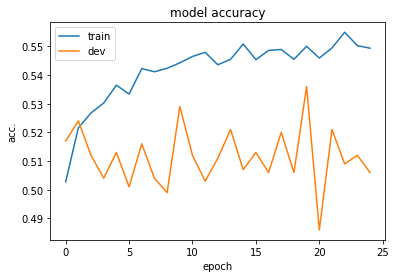

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 
                    
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc.')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

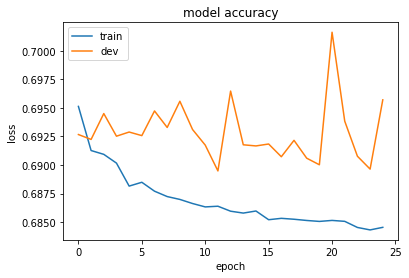

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline 
                    
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [16]:
best_idx = np.argmax(history.history['val_accuracy'])
print("Best accuracy on dev: {} (epoch {})".format(history.history['val_accuracy'][best_idx], best_idx))

Best accuracy on dev: 0.5360000133514404 (epoch 19)


**Reproducible models**
Run the code below if you want to train your model from scratch. 

`Clear_session` will destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers.

In [17]:
from keras.backend import clear_session
clear_session()

<a id='section4_model_optimization'></a>
### 4.1 Model Optimization

How much can we improve the current classifier? We can follow multiple strategies to improve the performance of our model: 

- **Increase training size**: Usually this is the most effective way to improve the resuls, but it is the most costly at the same time. In our case we are using the whole dataset, so we can't exploit this estrategy (you can simulate by using smaller set of training as baseline).

- **Increase vocabulary**: We are not using the whole vocabulary of the training set. Vocabulary pruning can be useful to avoid overfiting, but can affect generalization properties as well.

- **The use of correct neural archictecture**: We can increase the expresivity of the model by adding more parameters in different forms: 1) increasing number of hidden layers, 2) increasing the size of layers, 3) combining both. 

- **The use of correct optimization strategy**: We can try more effective optimizers than SGD. For example, Adam optimizer is one of the most popular in NLP. In many cases correct learning rate value makes a difference. So exploring different learning rate values can be interesting choice to improve results.

- **Number of epochs**: How long we traing is something we need too control as training to long can derive to overfit the model. On the contrary, if we train for a short time the model will hardly learn anything. There are different ways to select number of training epochs, but a common one is to inspect learning curves and select the point that has lower loss in development. 

- **Regularization weight, dropout, batch size, etc.**: Deep learning is full of hyperparameters and small *tricks* that are important to know. Each model in a particular task has its own optimum values which we don't know in advance. 


<a id='exercise4'></a>
#### Exercise 4: 
 * Explore what happens when we use the whole vocabulary instead to the most 1000 frequent words.
 * It looks like learning is quite unstable as the accuracy on development fluctuates quite significantly. Select a smaller learning rate (e.g. 0.1 or even smaller). You'll probably need to train longer.   
 * Now, explore what happens when we increase the model (e.g. 300 > 50 > 1). You might need to adjust the learning rate and the number of epochs. 
 * Now, explore with a different optimizer (e.g Adam).
 
 What's your best accuracy and model's detail?

In [47]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

# In order to use the whole vocabulary you need to preprocess the data again.
# You can use the code in section 2.3

# TODO: 
# Create a tokenizer object with 'num_words=None' as argument.
tokenizer = text.Tokenizer(num_words=None)

# TODO:
# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part

# TODO:
# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts, mode='binary')
x_dev = tokenizer.texts_to_matrix(dev_texts, mode='binary')

# Change variable names (not needed, actually)
y_train = train_labels
y_dev = dev_labels

nb_words = x_train.shape[1]
print(x_train.shape)

(9000, 17353)


New input size: 17353


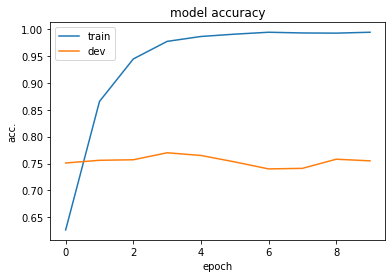

In [48]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
%matplotlib inline

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.
print("New input size: {}".format(input_size))

# TODO:
# Define the model
model_av = Sequential()
model_av.add(Dense(units=300, activation='relu', input_shape=(input_size,)))
model_av.add(Dense(units=50, activation='relu'))
model_av.add(Dense(units=1, activation='sigmoid'))  
    
# TODO: 
# Define the optimizer (SGD, Adam, etc.)
sgd = SGD(lr=0.1)
adam = Adam(lr=0.1)

# TODO:
# Compile the model using a loss function and an optimizer.
model_av.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# TODO: 
# Fit the model with the appropiate number of epochs and batch size
history_av = model_av.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_dev, y_dev), verbose=0)

# summarize history for accuracy
plt.plot(history_av.history['accuracy'])
plt.plot(history_av.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc.')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [49]:
best_idx = np.argmax(history_av.history['val_accuracy'])
print("Best accuracy on dev: {} (epoch {})".format(history_av.history['val_accuracy'][best_idx], best_idx))

Best accuracy on dev: 0.7699999809265137 (epoch 3)


In [53]:
from keras.backend import clear_session
clear_session()

<a id='section5'></a>
## 5. Other models for text: LSTM

When working with text it is typical to model the input as it would be time dependent series. Due to compositional nature of language, we could encode the semantics of the context conditioning on previous seen words, and **Deep Recurrent Neural Networks** are suitable to model these ideas. 

In this section, we will use Keras to implement a more advanced __Long Short Term Memory__ (LSTM) based sentiment classifier. 

----

Remenber from the theory that Recurrent Neural Networks apply over and over the same function (the recursive cell) to every token in the sequence. In a simplified version the next token is combined with the output of the previous _state_ (contains the information of what has been seen so far) into the recursive function, so that the whole sequence is represented in a single vector. 

Figure below shows an unrolled LSTM archicture, in which input text sequence, once tokenized and obtained the word index, is represented by word embeddings. Emebdding lookup layer takes a list of word indexes and returns a list word embeddings (low-dimensional dense vectors that represent words). These word embeddings are what actually fed to sentence encoder. Finally, the last output of the LSTM is fed to a fully connected Dense layer. As we'll learn, this is fairly easy to code with Keras.


![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/LSTM_sentiment.png)

---

<a id='section5_padding'></a>
### Padding sequences
When process data to feed a recurrent archicture, we need to do it differently compared to what we have seen so far. Unrolling each sequence one by one would take forever, as we would lose the capability for parallelization. That's why we need to pad the input sentences. That is, as learning is typically done by mini-batching the training data, it requires having same sequence length for all the input examples in the mini-batch so we can run the operation in parallel over the whole batch.

In order to do mini-batch we need to do the following:
- Choose a single unrolling constant N (e.g. max sequence length)
- Pad first words with zeros (shifting right)


There are more sophisticated alternivatives like shuffling examples by sentence length (set N to max. length in mini-batch), but for our purposes that would be enough. 

In the following chunk of code, we will use Keras built-in functions for padding sequence. Note that tokenization and word-indexing is already done in <a href='#section2_one_hot'>Section 2.3 (One-hot encoding of the data)</a>.

In [54]:
# Recall from previous code sections:
# - training text examples: train_texts
# - training labels: train_labels
#
# - development text examples: dev_texts
# - development labels: dev_labels

from keras import preprocessing

# Define maximum sequence length
max_seq = 40 

# Get data as a lists of integers
train_sequences = tokenizer.texts_to_sequences(train_texts)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
nb_words = len(tokenizer.word_index) + 1

# Padding data: Turn the lists of integers into a 2D integer tensor of shape `(samples, max_seq)`
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_seq)
x_dev = preprocessing.sequence.pad_sequences(dev_sequences, maxlen=max_seq)

y_train = train_labels
y_dev = dev_labels

print('Shape of the training set (nb_examples, vector_size): {}'.format(x_train.shape))
print('Shape of the validation set (nb_examples, vector_size): {}'.format(x_dev.shape))

# Print some examples
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts[0], x_train[0]))
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts[1], x_train[1]))

Shape of the training set (nb_examples, vector_size): (9000, 40)
Shape of the validation set (nb_examples, vector_size): (1000, 40)

TEXT: suffocated at conception by its munchausen by proxy mum punish the vehicle to adore the star
PADDED: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 6416   32 4041   25
   19 9134   25 9135 9136 9137    1 1174    5 9138    1  239]

TEXT: this loud and thoroughly obnoxious comedy about a pair of squabbling working class spouses is a deeply unpleasant experience
PADDED: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   16  686    3  715 2038   58   30
    2 2267    4 9139  687  526 6417    6    2  492 1334  312]


<a id='exercise5'></a>
#### Exercise 5
>Differences of the embedding representation with the one-hot encoding.
>- Do we keep now the temporal order of words?
>- What is one of the goal of the embedding table? Would be possile to apply LSTMs to text with the one-hot encoding representation?

----

<a id=section5_lstm></a>
### Build a LSTM model in few lines
In this section we will build our first LSTM-based classifier in Keras. Note that the LSTM layer, like the rest of layers in Keras, takes inputs of shape ```[batch_size, sequence_length, input_features]```. This is the reason of why we perform padding when preprocessed the data in the previous section.

Note that after the padding our data still is 2D tensor of shape ```[batch_size, sequence_length]```. Transformation from 2D to 3D is done with```Embedding``` layer in Keras, which takes the 2D tensor (```[batch_size, sequence_length]```). ```sequence_length``` is an entry of a list of word indexes, where all the entries in the bacth have the same length. (That's why we padded with zeros the shorter sequences).

```Embedding``` layer return a tensor of shape ```[batch_size, sequence_length, embedding_size]```. This can be understood like adding the corresponding embedded vector to each word in the sequence. The layer can be initialized at radom and learn with backpropagation, or use precomputed embedding vector like _Word2vec_ or _Glove_.

Once our data is represented with 3D tensors we can use directly the ```LSTM``` layer. For this task we will combine three Keras layers in this specific order: 

- ```Embedding``` layer: it will transfor the data from 2D to 3D by adding associated embeddings to words in the sequences. In the constructor we need to specify two arguments: 
   - input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
   - output_dim: int >= 0. Dimension of the dense embedding.
   
- ```LSTM``` layer: It will encode the input sequnces and return output tensor. For the LSTM we need to specify the number of units of the LSTM:
   - units: Positive integer, dimensionality of the output space.
   
- ```Dense```: It will take the output of the LSTM as input and perform the classification. 


<a id='exercise6'></a>
#### Exercise 6: 
> Complete the code to turn it into a LSTM. You just need to add the LSTM layer in Keras, and another layer for classification. 

In [57]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam, RMSprop

# nb_words defined above 
print('Vocabulary size: {}'.format(nb_words))
embedding_size = 128

# TODO: Use this
lstm_hidden_size = 128 

model = Sequential()

# 1. Define and add Embedding layer to the model. 
#    Note we are using mask_zero=True as we want to ignore the '0' words in the padding
model.add(Embedding(nb_words, embedding_size, mask_zero=True))
# After the Embedding layer, 
# our activations have shape `(batch_size, max_seq, embedding_size)`.

# TODO: 
# 2. Define and add LSTM layer to the model.
model.add(LSTM(units=lstm_hidden_size, activation='relu'))


# TODO:
# 3. Define and add Dense layer to the model
model.add(Dense(units=1, activation='sigmoid'))  


# Define optimizer:
opt=Adam(lr=0.001)
# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Vocabulary size: 17353
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2221184   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,352,897
Trainable params: 2,352,897
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_dev, y_dev), verbose=1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 13s 1ms/step - loss: 0.6543 - accuracy: 0.6121 - val_loss: 0.5448 - val_accuracy: 0.7550
Epoch 2/10
9000/9000 [==============================] - 16s 2ms/step - loss: 0.3736 - accuracy: 0.8480 - val_loss: 0.4879 - val_accuracy: 0.7580
Epoch 3/10
9000/9000 [==============================] - 16s 2ms/step - loss: 0.1788 - accuracy: 0.9356 - val_loss: 0.5940 - val_accuracy: 0.7820
Epoch 4/10
9000/9000 [==============================] - 18s 2ms/step - loss: 0.0961 - accuracy: 0.9664 - val_loss: 0.8507 - val_accuracy: 0.7580
Epoch 5/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.0504 - accuracy: 0.9827 - val_loss: 0.9336 - val_accuracy: 0.7650
Epoch 6/10
9000/9000 [==============================] - 16s 2ms/step - loss: 0.0884 - accuracy: 0.9763 - val_loss: 1.5969 - val_accuracy: 0.7580
Epoch 7/10
9000/9000 [==============================] - 15s 2ms/step - loss: 0.044

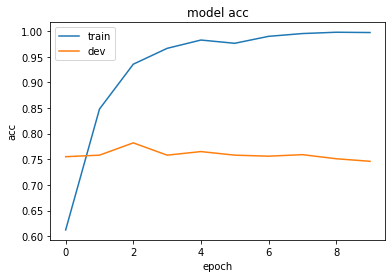

In [59]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [60]:
best_idx = np.argmax(history.history['val_accuracy'])
print("Best accuracy on dev: {} (epoch {})".format(history.history['val_accuracy'][best_idx], best_idx))

Best accuracy on dev: 0.7820000052452087 (epoch 2)


In [61]:
from keras.backend import clear_session
clear_session()

----

<a id='section5_cnn'></a>
### 1D CNNs for texts (optional)

The model architecture for texts are much like a 2D CNN that are tipically used in computer vision. Instead of having two dimension for applying convolutional filters, in this case, due to the sequential nature of the data, convolutions are applied along one axis (See image below). 

CNN based archictures for sentence classification have tipically the following layers:

- __Convolutional layer__: It uses convolutions that extracts local 1D patches (subsequences) from the input sentences. Recall that word indeces are first transformed to embedding space. This type of convolutions can recognize local patterns such as bigrams and trigrams.  As explained in class, convolution layers change the shape of the input sequence. Depending on the type of padding and stride the length of the output would be longer, same size, or shorter. The depending on the number of filters used the output depth would change as well.

  If ```padding = 'same'```, then the spatial dimensions of the convolutional layer are the following:

  ```output_length = ceil(input_length / stride)```

  If ```padding = 'valid'```, then the spatial dimensions of the convolutional layer are the following:

  ```output_length = ceil(input_length - kernel_size + 1) / stride)```


- __Max-pooling layer__: The main objective is to reduce drastically the output size of the convolution layers. 1D pooling operation is the same as the 2D. It takes 1D subsequences from convolutional output as input and return the maximum value. Similarly to convolutional layer, depending on the ```pool_size```, ```stride``` and ```padding``` we'd obtain different reduction of the input size.

- __Fully connected layer__: We can flatten the output of the max-pooling layer and feed to fully-connected layer to perform _positive_ vs _negative_ classification.


>>>![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/CNN_for_texts.png)

<a id='exercise7'></a>
#### Exercise 7 (optional)
Following the idea explained in the introduction of the notebook, you will stack two layers of ```convolution+max-pooling```. Note that the last layer of max-pooling is ```GlobalMaxPooling1D```, which returns a flat vector that can be directly feed in the ```Dense``` layer for doing classification.

__Hint__: You need to combine the following keras layers:
- ```Embedding```
- ```Conv1D```
- ```MaxPoolling1D```
- ```GlobalMaxPooling1D```
- ```Dense```

In [74]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop

max_words = nb_words ## defined above
max_seq = 40 ## defined above
embedding_size = 128 
output_filters = 32

model = Sequential()

# TODO: Define the model. conv1d+max_pooling + convd1+globalmaxpooling + dense
#       Activations. Typically RELU works OK in this type of tasks.
model.add(Embedding(nb_words, embedding_size, input_length=max_seq))

model.add(Conv1D(filters=output_filters, kernel_size=10, activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(filters=output_filters, kernel_size=10, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(units=1, activation='sigmoid'))  

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 40, 128)           2221184   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 31, 32)            40992     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 6, 32)             10272     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,272,481
Trainable params: 2,272,481
Non-trainable params: 0
___________________________________________

In [75]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_dev, y_dev))

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 4s 444us/step - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.4990
Epoch 2/20
9000/9000 [==============================] - 3s 327us/step - loss: 0.6903 - acc: 0.5611 - val_loss: 0.6928 - val_acc: 0.5100
Epoch 3/20
9000/9000 [==============================] - 3s 336us/step - loss: 0.6869 - acc: 0.6201 - val_loss: 0.6922 - val_acc: 0.5140
Epoch 4/20
9000/9000 [==============================] - 3s 310us/step - loss: 0.6827 - acc: 0.6743 - val_loss: 0.6902 - val_acc: 0.5310
Epoch 5/20
9000/9000 [==============================] - 3s 321us/step - loss: 0.6763 - acc: 0.7068 - val_loss: 0.6861 - val_acc: 0.5730
Epoch 6/20
9000/9000 [==============================] - 3s 319us/step - loss: 0.6660 - acc: 0.7214 - val_loss: 0.6769 - val_acc: 0.6180
Epoch 7/20
9000/9000 [==============================] - 3s 303us/step - loss: 0.6475 - acc: 0.7353 - val_loss: 0.6601 - val_acc: 0.6420


-----

# PART 2: Word Embeddings

In this part of the lab session we will learn what kind of thing can be don with the word embeddings. 

We will focus in three task:
- __Task 1__: Word similarity and relatedness
- __Task 2__: Score semantically the words
- __Task 3__: Do analogies, like _Man is to King like Woman is to Queen_

But as always, We will start setting up the environment and loading the data . 

<a id='section6'></a>
## Set up 

We first define some helper functions for printing results and reading embeddings.

In [ ]:
import numpy as np

def print_header(title):
    print('┌───────────────────────────────────────────────────────────────┐')
    print('│{0:^63}│'.format(title))
    print('├──────────┬─────────────────────────────┬──────────┬───────────┤')

def print_footer():
    print('└──────────┴─────────────────────────────┴──────────┴───────────┘')

def print_oov(oov):
    if len(oov) > 0:
        print('OOV: {0}'.format(', '.join(oov)))

def print_row(index, last, trg_words, knn, sim):
    if last >= index or index < 0:
        return last
    if last < index - 1:
        print('│  {0:>5}  │  {0:^25}  │  {0:>5}   │  {0:^7} │'.format('⋮'))
    word = trg_words[knn[index]]
    word = ('{0:^25}').format(word)
    print('│  {0:>6}  │  {1}  │  {2:>6}  │  {3:7.4f}  │'.format(index + 1, word, knn[index], sim[knn[index]]))
    return index

def read(file, threshold=0, dim=50, vocabulary=None):
    count = 400000 if threshold <= 0 else min(threshold, 400000)
    words = []
    matrix = np.empty((count, dim)) if vocabulary is None else []
    for i in range(count):
        word, vec = file.readline().split(' ', 1)
        if vocabulary is None:
            words.append(word)
            matrix[i] = np.fromstring(vec, sep=' ')
        elif word in vocabulary:
            words.append(word)
            matrix.append(np.fromstring(vec, sep=' '))
    return (words, matrix) if vocabulary is None else (words, np.array(matrix))

def length_normalize(matrix):
    norms = np.sqrt(np.sum(matrix**2, axis=1))
    norms[norms == 0] = 1
    return matrix / norms[:, np.newaxis]

<a id='section6_load'></a>
### Load data

First let's load a set of 50D word vectors from GloVe. Original files can be downloaded at this [url](http://nlp.stanford.edu/data/glove.6B.zip). The zip file includes embeddings of different dimensionality (50d, 100d, 200d, 300d) for a vocabulary of 400000 words.

We already provide you the required file, which is specifified in 
`glove_home`. 

Variables like `matrix` and `word2ind` are used below in the notebook so you need first load data in order to make everything work.

In [ ]:
# Read input embeddings
glove_home = 'data/embeddings/glove.6B.50d.txt'
embsfile = open(glove_home, encoding='utf-8', errors='surrogateescape')
words, matrix = read(embsfile)

# Length normalize embeddings so their dot product effectively computes the cosine similarity
matrix = length_normalize(matrix)

# Build word to index map
word2ind = {word: i for i, word in enumerate(words)}

<a id='section7'></a>
## Task 1: Semantically similar/related words

In [ ]:
def knn(word, k=10):
    try:
        i = word2ind[word]
        sim = matrix[i].dot(matrix.T)
        knn = np.argsort(-sim)
    except KeyError:
        print_header('{0} (OOV)'.format(word))
        print_footer()
        print()
        return
    print_header('{0} ({1})'.format(word, i + 1))
    last = -1
    for j in range(len(knn)):
        word = words[knn[j]]
        if j < k:
            last = print_row(j, last=last, trg_words=words, knn=knn, sim=sim)
    last = print_row(len(knn)-1, last=last, trg_words=words, knn=knn, sim=sim)
    print_footer()
    print()

`knn` function retrieve the _k_ most similar/related words of the target word according to the given embedding space. The output looks like the following:

   - fist column for nearest neighbour index
   - second column for nearest neighbour word
   - third column for index of word in frequency ranking (1 is most frequent)
   - last column for cosine (1 for perfect similarity)

<a id='exercise8'></a>
#### Exercise 8
>Check the results for the words below. List which words you think are working well, and which ones it is failing. You can use the example in the slide  as reference.
>
>- france, jesus, xbox, reddish, scratched, megabits 


In [ ]:
knn('jesus',k=30)
knn('france', k=30)

<a id='section8'></a>
## Task2: Semantic Orientation
The __semantic orientation__ method of [Turney and Littman 2003](http://doi.acm.org/10.1145/944012.944013) is a method for automatically scoring words along some single semantic dimension like sentiment. It works from a pair of small seed sets of words that represent two opposing points on that dimension.

In [ ]:
seed_pos = ['good', 'great', 'awesome', 'like', 'love']
seed_neg = ['bad', 'awful', 'terrible', 'hate', 'dislike']

def determine_coefficient(candidate_word, seed_pos, seed_neg):
    pos_ind = np.array([word2ind[word] for word in seed_pos])
    pos_mat = matrix[pos_ind]

    neg_ind = np.array([word2ind[word] for word in seed_neg])
    neg_mat = matrix[neg_ind]

    i = word2ind[candidate_word]

    pos_sim = np.sum(matrix[i].dot(pos_mat.T))
    neg_sim = np.sum(matrix[i].dot(neg_mat.T))

    return pos_sim - neg_sim

print(determine_coefficient('abhorrent', seed_pos, seed_neg))
print(determine_coefficient('vacations', seed_pos, seed_neg))
print(determine_coefficient('hunger', seed_pos, seed_neg))

And sort our vocabulary by its score along the axis. For now, we're only scoring frequent words, since this process can be slow.

In [ ]:
from operator import itemgetter

scored_words = [(word, determine_coefficient(word, seed_pos, seed_neg)) for word in words[1:5000]]
sorted_words = sorted(scored_words, key=itemgetter(1), reverse=True)

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(sorted_words[:10])
print()
pp.pprint(sorted_words[-10:])

<a id='exercise9'></a>
#### Exercise 9

> Spend a few minutes exploring possible seed sets for semantic dimensions other than sentiment (e.g. "animals" vs "tools"). 
>- Define your semantic orientation with the two sets of seeds.


<a id='section9'></a>
## Task 3: Analogy
Next, let's try to build a similar function for determining which words are likely to be good completions for an analogy. Our inputs will be a pair and a singleton word that together represent an analogy problem.

- Analogy pair:  good $\rightarrow$ best,  man $\rightarrow$ king
- Analogy problem: bad $\rightarrow$ ??,  woman $\rightarrow$ ??


Remenber from slides:

- Task: _a is to b as c is to?_
    + $a-b \approx c-d$
    + $c-a+b \approx d$
    + $argmax_{d\in V} (cos(d , c−a+b))$

In [ ]:
def analogy(pront_pair, pront_seed, k=10):
    # The function make use of embedding matrix and word indices.
    # Recall to load data and inialize matrix and word2ind variables.
    try:
        i = word2ind[pront_pair[0]]
        w1v = matrix[i]
    except KeyError:
        print_header('{0} (OOV)'.format(pront_pair[0]))
        print_footer()
        print()
        return
    try:
        i = word2ind[pront_pair[1]]
        w2v = matrix[i]
    except KeyError:
        print_header('{0} (OOV)'.format(pront_pair[1]))
        print_footer()
        print()
        return
    try:
        i = word2ind[pront_seed]
        w3v = matrix[i]
    except KeyError:
        print_header('{0} (OOV)'.format(pront_seed))
        print_footer()
        print()
        return
    
    ########### YOUR SOLUTION HERE
    

    ###########

    print_header('{0} - {1} + {2}'.format(pront_pair[0], pront_pair[1], pront_seed))
    last = -1
    for j in range(len(knn)):
        word = words[knn[j]]
        if j < k:
            last = print_row(j, last=last, trg_words=words, knn=knn, sim=sim)
    last = print_row(len(knn)-1, last=last, trg_words=words, knn=knn, sim=sim)
    print_footer()
    print()


<a id='exercise10'></a>
#### Exercise 10
>-  The embeddings space can be used to do analogies. Please examine the formula in the of slides, and apply it to the three embeddings in the function below `analogy`. If you programmed it correctly, the following analogy should work:
>    + `man:king; woman:?` (Note that, in the result list, words in the query need to be ignored)
>    
>
>- Check 10 of the analogie below and see the position of the correct answer (discounting the words in the query).

>>> ![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/analogy_exercise.png)

----

In [ ]:
analogy(['france', 'paris'], 'japan')

----
<a id='section10'></a>
## Visualization (optional)
Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# reduce size of the matrix to speed up the operations
viz_words = 500
start_ind = 1000
end_ind = start_ind+viz_words
small_ind = np.array([word2ind[word] for word in words[start_ind:end_ind]])
small_word2ind = {word : i for i, word in enumerate(words[start_ind:end_ind])}
small_matrix =  matrix[small_ind]

# Project word embeddings to two-dimensions
tsne = TSNE()
embed_tsne = tsne.fit_transform(small_matrix)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
plt.scatter(x=embed_tsne[:,0], y=embed_tsne[:,1], c='steelblue')
for i, word in enumerate(words[start_ind:end_ind]):
    plt.annotate(word, (embed_tsne[small_word2ind[word], 0], embed_tsne[small_word2ind[word], 1]), alpha=0.7)

##### <a id='exercise10'></a>
#### Exercise 10 (optional)
> It would be interesting to color each point according to their semantic oreintation (e.g positive vs negative). For that, you could use the result obtained in Task2.